In [0]:
import os
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # used to create png image files

In [2]:
from google.colab import drive
drive.mount('/content/drive')
wine_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/winequality-red.csv", sep=';')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **V.4 Advanced wine sampling and resampling**

*   validation set = holdout method
*   k-fold cross-validation



a) Write a function that uses the holdout method to partition the red wine data into a training and a validation set. The function should take a parameter to adjust the proportion of training to validation data. It should return a tuple containing:

(training_pandas_dataframe, validation_pandas_dataframe)


In [0]:
def ft_dot(a, b):
    result = 0
    for i in range(len(a)):
        result += a[i] * b[i]   
    return result

In [0]:
# sigmoid activation function is needed because of exploding gradients
# https://www.quora.com/Based-on-your-experience-with-training-Adaline-neural-networks-have-you-noticed-that-weights-have-a-tendency-to-explode/answer/Leo-Mauro?__filter__=&__nsrc__=2&__sncid__=3468645059&__snid3__=5684144952
# SQUARED ERROR ???

class Adaline(object):
  def __init__(self, lr):
    self.w = None
    self.lr = lr
    self.stats = []

  def _net_input(self, X):
    return ft_dot(self.w, X)

  def _activation_function(self, X):
    net_input = self._net_input(X)
    return 1 / (1 + math.exp(-net_input))

  def predict(self, X):
    return 1 if self._activation_function(X) > 0.5 else 0

  def _eval_epoch(self, X, y):
    num_misclass = 0
    for xi, yi in zip(X, y):
      num_misclass += int(self.predict(xi) != int(yi))
    return num_misclass

  def _train_epoch(self, X, y, epoch, mode, verbose):
    # m length vector of errors of all samples
    # continuous error
    epoch_errors = []

    # zip returns a row of matrix X and an element of vector y
    for xi, yi in zip(X, y):
      yhat = self._activation_function(xi)
      error = yi - yhat
      epoch_errors.append(error)

      # stochastic
      # note, we do not aggregate the error over the entire training sample
      if mode == 'online':
        self.w += self.lr * error * xi

    if mode == 'batch':
      self.w += self.lr * ft_dot(X, epoch_errors)

    num_misclass = self._eval_epoch(X, y)
    if verbose and epoch % 10 == 0:
      print('Epoch {}: {} errors'.format(epoch, num_misclass))
    self.stats.append((epoch, num_misclass, self.w))
    return epoch_errors

  def train(self, X, y, epochs, mode='batch', verbose=False, seed=None):
    if seed:
      random.seed(seed)
    if self.w is None:
      self.w = [0.001 * random.uniform(-1, 1) for i in range(X.shape[1])]
    epoch = 0
    while True:
      epoch_errors = self._train_epoch(X, y, epoch, mode, verbose)
      epoch += 1
      if epochs != 0 and epoch == epochs:
        break
      elif epochs == 0 and epoch_errors == 45: # this will never happen under pure adaline !!!
        break
    return self.stats

  def test_accuracy(self, X, y):
    num_correct = 0
    for xi, yi in zip(X, y):
      num_correct += int(int(yi) == self.predict(xi))
    accuracy = num_correct / len(y)
    print('Test accuracy {} {} {}%'.format(num_correct, len(y), 100*accuracy))
    return accuracy

In [0]:
def plot_errors(ax, stats, epoch):
  epochs = [t[0] for t in stats[:epoch + 1]]
  epoch_errors = [t[1] for t in stats[:epoch + 1]]
  ax.plot(epochs, epoch_errors)
  ax.set_title('Errors as a function of epochs')
  ax.set_xlabel('epoch')
  ax.set_ylabel('classification errors')

def plot_decision_boundary(ax, stats, epoch, X, y, features, good_thresh, bad_thresh):

  x_min = X.loc[:, features[0]].min() - .2
  x_max = X.loc[:, features[0]].max() + .2
  y_min = X.loc[:, features[1]].min() - .2
  y_max = X.loc[:, features[1]].max() + .2

  ax.set_title('Decision Boundary on epoch:  {}'.format(epoch))
  ax.set_xlabel(features[0])
  ax.set_ylabel(features[1])
  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])

  w0, w1, w2 = stats[epoch][2]
  slope = -w1/w2
  intercept = -w0/w2

  # +2 is used to help shade the entire region
  x_coords = [x_min + (x_max + 2 - x_min) * i/10 for i in range(10)]
  y_coords = [intercept + slope * i for i in x_coords]

  ax.plot(x_coords, y_coords, 'b--', label='Decision Boundary')
  ax.fill_between(x_coords, y_coords, y_min - 2, color='#99ff99', alpha=.5)
  ax.fill_between(x_coords, y_coords, y_max + 2, color='#ff9999', alpha=.5)

  good_wines = X[y['y'] == True]
  ax.scatter(good_wines[features[0]], good_wines[features[1]], c=['g'], edgecolor='black', linewidth=2, alpha=0.65, label='good wines %d'%(good_thresh))
  bad_wines = X[y['y'] == False]
  ax.scatter(bad_wines[features[0]], bad_wines[features[1]], c=['r'], edgecolor='black', linewidth=2, alpha=0.65, label='bad wines %d'%(bad_thresh))
  ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

def plot_stats(stats, X, y, features, good_thresh, bad_thresh, epoch=-1):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
  if epoch > len(stats) - 1:
    raise ValueError('Number of epochs should be less than {}'.format(len(stats)))
  if epoch == -1:
    epoch = len(stats) - 1
  plot_errors(ax[0], stats, epoch)
  plot_decision_boundary(ax[1], stats, epoch, X, y, features, good_thresh, bad_thresh)
  return fig

In [0]:
def feature_scaling(series):
  return (series - series.mean()) / (series.max() - series.min())

## HOLDOUT METHOD

In [0]:
# RESET DATA
good_threshold = 7
bad_threshold = 4
# filter data to only include data that meets threshold requirements
selected_wine_data = wine_data[(wine_data['quality'] >= good_threshold) | (wine_data['quality'] <= bad_threshold)]
# introduce a y column that equals 1 if good and 0 if bad
selected_wine_data = selected_wine_data.assign(y = pd.Series(selected_wine_data['quality'] >= good_threshold))

# feature scaling, applied only to X inputs, not to y targets !
selected_wine_data['pH'] = feature_scaling(selected_wine_data['pH'])
selected_wine_data['alcohol'] = feature_scaling(selected_wine_data['alcohol'])

In [0]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

def train_test_split(data, test_size=0.3):
  train_set = data.sample(frac=(1 - test_size)) # 70% for training, randomly sampled.
  test_set = data.drop(train_set.index) # excluding training set data
  print('Train set {}'.format(train_set.shape))
  print('Test set {}'.format(test_set.shape))
  return (train_set, test_set)

In [19]:
# CREATE X_TRAIN, y_TRAIN, X_TEST, y_TEST

data = selected_wine_data
test_size = 0.3
train_set, test_set = train_test_split(data=data, test_size=test_size)

X_train = train_set.loc[:, ['alcohol', 'pH']]
X_train.insert(0, 'x0', 1)
X_train = X_train.reset_index(drop=True)
y_train = train_set.loc[:, ['y']]
y_train = y_train.reset_index(drop=True)

X_test = test_set.loc[:, ['alcohol', 'pH']]
X_test.insert(0, 'x0', 1)
X_test = X_test.reset_index(drop=True)
y_test = test_set.loc[:, ['y']]
y_test = y_test.reset_index(drop=True)

Train set (196, 13)
Test set (84, 13)


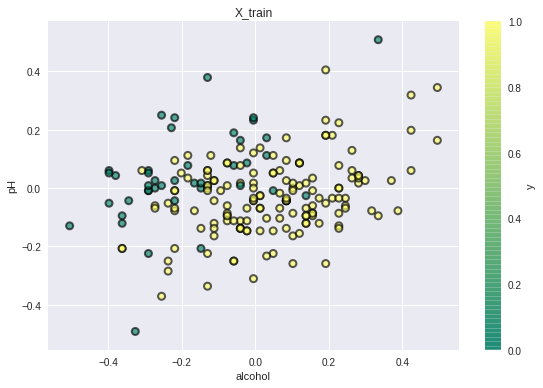

In [20]:
# SCATTER PLOT OF X_TRAIN DATA

plt.style.use('seaborn')
plt.scatter(X_train['alcohol'], X_train['pH'], c=y_train['y'], cmap='summer', edgecolor='black', linewidth=2, alpha=0.65)
# s=100 makes the dot larger
# c='green', for color green
# marker='X', to make dot into X
# edgecolor, edge color of the dots
# linewidth, how thick are the edges circles around the dots
# alpha, to soften the color of the green dots
# c=colors gives you different color for the dots
# cmap='Greens', gives you different shades of green instead of grey
cbar = plt.colorbar()
cbar.set_label('y')
plt.title('X_train')
plt.xlabel('alcohol')
plt.ylabel('pH')
plt.tight_layout()

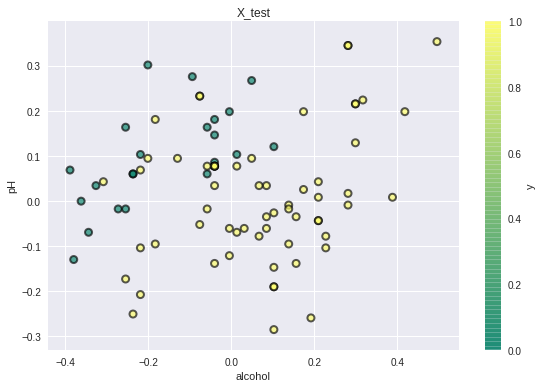

In [21]:
# SCATTER PLOT OF X_TEST DATA

plt.style.use('seaborn')
plt.scatter(X_test['alcohol'], X_test['pH'], c=y_test['y'], cmap='summer', edgecolor='black', linewidth=2, alpha=0.65)
# s=100 makes the dot larger
# c='green', for color green
# marker='X', to make dot into X
# edgecolor, edge color of the dots
# linewidth, how thick are the edges circles around the dots
# alpha, to soften the color of the green dots
# c=colors gives you different color for the dots
# cmap='Greens', gives you different shades of green instead of grey
cbar = plt.colorbar()
cbar.set_label('y')
plt.title('X_test')
plt.xlabel('alcohol')
plt.ylabel('pH')
plt.tight_layout()

Test accuracy 68 84 80.95238095238095%


0.8095238095238095

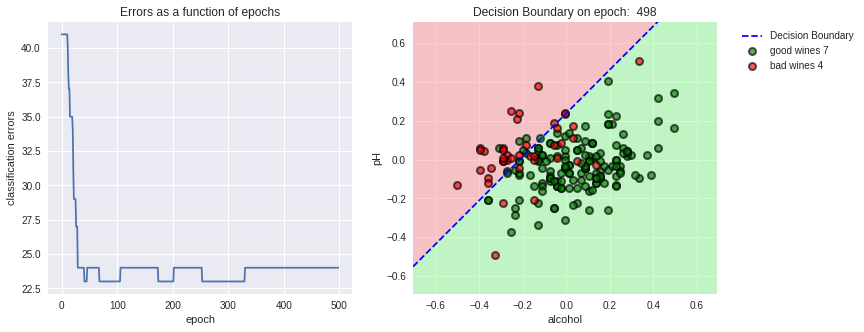

In [22]:
# HOLDOUT METHOD: ONLY TRAINING WITH TRAINING SET

ad = Adaline(lr=0.05)
epochs = 500
mode = 'batch'
stats_ad = ad.train(X_train.values, y_train.values, epochs=epochs, mode=mode, verbose=False)

good_threshold = 7
bad_threshold = 4
epoch = epochs - 2
features = ['alcohol', 'pH']
fig = plot_stats(stats_ad, X_train, y_train, features, good_threshold, bad_threshold, epoch=epoch)

ad.test_accuracy(X_test.values, y_test.values)

NOTE - FEATURE SCALING HELPS REMOVE THE WHIPPINESS OF CLASSIFICATION ERRORS.

# **K-FOLD CROSS VALIDATION**

b) Write a function that generates a k-fold cross-validation dataset from the red wine data. The function should allow k to be arbitrarily adjusted and also have an optional setting to shuffle data before creating k-folds. The function should return a list of ‘k’ tuples with each tuple containing:

(training_pandas_dataframe, cross_validation_pandas_dataframe)


A quick way to check if the fold sizes are representative is to calculate summary statistics such as mean and standard deviation and see how much the values differ from the same statistics on the whole dataset.

https://machinelearningmastery.com/implement-resampling-methods-scratch-python/

In [0]:
# // floor division

def k_fold_split(data, k, shuffle=True):
  folds = []
  if shuffle:
    data = data.sample(frac=1).reset_index(drop=True)
    # sampling 100% here

  for i in range(k):
    size = data.shape[0] // k + 1 if i < data.shape[0] % k else data.shape[0] // k
    test_data = data.iloc[i * size: (i + 1) * size, :]
    train_data = data.iloc[data.index.difference(test_data.index), :]
    folds.append((train_data, test_data))
  return folds

In [24]:
num_folds = 5
folds = k_fold_split(selected_wine_data, num_folds)

print('train, val lengths for {} folds: {}'.format(
    num_folds, [(len(train), len(val)) for train, val in folds]))

train, val lengths for 5 folds: [(224, 56), (224, 56), (224, 56), (224, 56), (224, 56)]


In [0]:
# if num_folds = 5, then we can examine the last fold by:
# folds[4][0][['pH', 'alcohol']] # for training data, because folds is a list.
# folds[4][1][['pH', 'alcohol']] # for testing data

c) What effects does changing learning rate and number of training epochs have on the ADALINE when evaluated via k-fold cross-validation? To address this question, you should write (or modify) a function that will train and assess the ADALINE on each training and cross-validation fold produced by your k-fold function.

In [0]:
# NOTE, WE ARE USING FEATURE SCALED DATA

In [0]:
def k_fold_adaline(folds, features, lr=0.05, epochs=500, mode='batch', verbose=False):
  sum_accuracy = 0

  for i, fold in enumerate(folds):
    X_train = fold[0][features]
    y_train = fold[0]['y']
    ad = Adaline(lr=lr)
    train_stats = ad.train(X_train.values, y_train.values, epochs, mode, verbose)
    X_test = fold[1][features]
    y_test = fold[1]['y']
    accuracy = ad.test_accuracy(X_test.values, y_test.values)
    sum_accuracy += accuracy

  print('K Fold: Mean accuracy {0:.3f}'.format(sum_accuracy / len(folds)))

In [26]:
features = ['pH', 'alcohol']
lr = 0.0005
epochs = 10
mode = 'batch'
k_fold_adaline(folds, features, lr=lr, epochs=epochs, mode=mode, verbose=False)

Test accuracy 42 56 75.0%
Test accuracy 44 56 78.57142857142857%
Test accuracy 38 56 67.85714285714286%
Test accuracy 31 56 55.35714285714286%
Test accuracy 46 56 82.14285714285714%
K Fold: Mean accuracy 0.718


In [0]:
features = ['pH', 'alcohol']
lr = 0.0005
epochs = 200
mode = 'batch'
k_fold_adaline(folds, features, lr=lr, epochs=epochs, mode=mode, verbose=False)

Test accuracy 39 56 0.6964285714285714%
Test accuracy 41 56 0.7321428571428571%
Test accuracy 45 56 0.8035714285714286%
Test accuracy 38 56 0.6785714285714286%
Test accuracy 37 56 0.6607142857142857%
K Fold: Mean accuracy 0.714


In [0]:
features = ['pH', 'alcohol']
lr = 0.05
epochs = 10
mode = 'batch'
k_fold_adaline(folds, features, lr=lr, epochs=epochs, mode=mode, verbose=False)

Test accuracy 41 56 0.7321428571428571%
Test accuracy 39 56 0.6964285714285714%
Test accuracy 45 56 0.8035714285714286%
Test accuracy 37 56 0.6607142857142857%
Test accuracy 36 56 0.6428571428571429%
K Fold: Mean accuracy 0.707


In [0]:
features = ['pH', 'alcohol']
lr = 0.05
epochs = 200
mode = 'batch'
k_fold_adaline(folds, features, lr=lr, epochs=epochs, mode=mode, verbose=False)

Test accuracy 43 56 0.7678571428571429%
Test accuracy 43 56 0.7678571428571429%
Test accuracy 43 56 0.7678571428571429%
Test accuracy 38 56 0.6785714285714286%
Test accuracy 37 56 0.6607142857142857%
K Fold: Mean accuracy 0.729


In [0]:
features = ['pH', 'alcohol']
lr = 0.5
epochs = 10
mode = 'batch'
k_fold_adaline(folds, features, lr=lr, epochs=epochs, mode=mode, verbose=False)

Test accuracy 43 56 0.7678571428571429%
Test accuracy 42 56 0.75%
Test accuracy 43 56 0.7678571428571429%
Test accuracy 38 56 0.6785714285714286%
Test accuracy 37 56 0.6607142857142857%
K Fold: Mean accuracy 0.725


In [0]:
features = ['pH', 'alcohol']
lr = 0.5
epochs = 200
mode = 'batch'
k_fold_adaline(folds, features, lr=lr, epochs=epochs, mode=mode, verbose=False)

Test accuracy 43 56 0.7678571428571429%
Test accuracy 43 56 0.7678571428571429%
Test accuracy 43 56 0.7678571428571429%
Test accuracy 38 56 0.6785714285714286%
Test accuracy 37 56 0.6607142857142857%
K Fold: Mean accuracy 0.729


In [0]:
features = ['pH', 'alcohol']
lr = 1
epochs = 10
mode = 'batch'
k_fold_adaline(folds, features, lr=lr, epochs=epochs, mode=mode, verbose=False)

Test accuracy 43 56 0.7678571428571429%
Test accuracy 42 56 0.75%
Test accuracy 43 56 0.7678571428571429%
Test accuracy 38 56 0.6785714285714286%
Test accuracy 37 56 0.6607142857142857%
K Fold: Mean accuracy 0.725


In [0]:
features = ['pH', 'alcohol']
lr = 1
epochs = 200
mode = 'batch'
k_fold_adaline(folds, features, lr=lr, epochs=epochs, mode=mode, verbose=False)

Test accuracy 43 56 0.7678571428571429%
Test accuracy 43 56 0.7678571428571429%
Test accuracy 43 56 0.7678571428571429%
Test accuracy 38 56 0.6785714285714286%
Test accuracy 37 56 0.6607142857142857%
K Fold: Mean accuracy 0.729


Given that we are using feature scaled data, the validation accuracy based on test data does not seem to vary by a lot between cases when we use low or high learning rate.  The same also goes for the case if we use low or high number of epochs for our training.

However, even though the mean accuracies are similar, the variability of the accuracies of the folds are greater, when we have fewer epochs or higher learning rate.

K-Fold Cross Validation helps to reduce a chance of an outlier in weight training.